## ***Kodon Kullanım Frekanslarına Dayalı Canlı Sınıflandırması ve LDA Performans Analizi***

Bu proje, canlıların DNA dizilimlerindeki kodon kullanım frekanslarını (codon usage frequencies) analiz ederek, bu canlıları ait oldukları biyolojik krallıklara (Kingdom — örn. Virüs, Bakteri, Bitki vb.) göre sınıflandırmayı amaçlamaktadır.
Veri seti, 64 farklı kodonun kullanım oranlarını, DNA tiplerini ve tür bilgilerini içermektedir.

Projede temel sınıflandırma algoritması olarak Lineer Diskriminant Analizi (LDA) seçilmiştir. Modelin başarısını artırmak ve veri setindeki en ayırt edici genetik özellikleri belirlemek amacıyla dört farklı yaklaşım karşılaştırılmıştır:

**Uygulanan Adımlar:**

1. **Veri Ön İşleme:** Hatalı veri tiplerinin düzeltilmesi, eksik verilerin doldurulması (Imputation) ve ölçeklendirme (Standard Scaling).
2. **Boyut İndirgeme ve Özellik Seçimi:** Model performansını artırmak ve hesaplama maliyetini düşürmek için üç farklı yöntem karşılaştırılmıştır:
    *   PCA (Temel Bileşen Analizi): Özellik çıkarma.
    *   SFS (Sıralı İleri Seçim): Sarmal (Wrapper) yöntem ile özellik seçimi.
    *   ANOVA (F-Testi): Filtreleme yöntemi ile istatistiksel olarak en anlamlı özelliklerin seçimi.
3. **Model Değerlendirme:** Her bir yöntem için F1 Skoru, ROC AUC ve Brier Skoru gibi metrikler hesaplanarak en iyi yaklaşım belirlenmiştir.


In [43]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from IPython.display import display


sns.set_style("whitegrid")

Veri Seti Boyutu: (13028, 69)


C:\Users\fidan\AppData\Local\Temp\ipykernel_9136\1476341141.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')


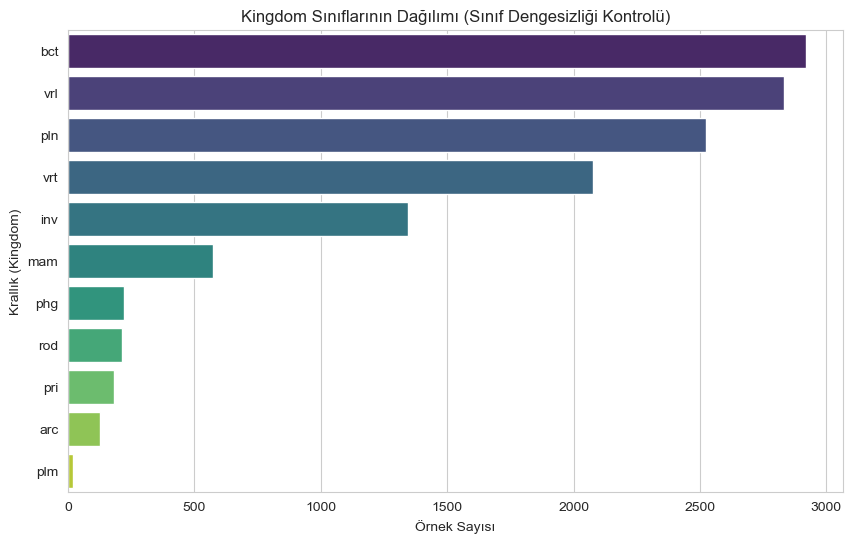

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [44]:
# Veri setini yükleme

df = pd.read_csv('C:\\Users\\fidan\\OneDrive\\Masaüstü\\codon_usage.csv', low_memory=False)  

print("Veri Seti Boyutu:", df.shape)

# Kingdom Sınıf Dağılımı grafik 
plt.figure(figsize=(10, 6))
sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')
plt.title('Kingdom Sınıflarının Dağılımı (Sınıf Dengesizliği Kontrolü)')
plt.xlabel('Örnek Sayısı')
plt.ylabel('Krallık (Kingdom)')
plt.show() 

# İlk 5 satırı göstermek için 
display(df.head())

### Veri Temizliği ve Tip Dönüşümü
Veri setindeki kodon frekansları bazen sayısal olması gerekirken "string" (metin) olarak algılanabilmektedir. Bu blokta:
*   Gereksiz sütunlar (`SpeciesID`, `SpeciesName`) atılır.
*   Sayısal sütunlardaki hatalı karakterler düzeltilir ve veri tipi sayısal formata (float) çevrilir.

In [45]:
codon_cols = df.columns[5:]

other_numeric_cols = ['Ncodons', 'DNAtype']
numeric_features = list(codon_cols) + other_numeric_cols

print("--- 3. Temizlik Başlangıç (Virgülden Noktaya çevirme) ---")
for col in numeric_features:
    if df[col].dtype == 'object':
        
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", ".", regex=False), 
            errors="coerce"
        )
        
df_cleaned = df.drop(columns=['SpeciesID', 'SpeciesName']).copy()

--- 3. Temizlik Başlangıç (Virgülden Noktaya çevirme) ---


###  Veri Setinin Eğitim ve Test Olarak Ayrılması
Veri sızıntısını önlemek için veri seti, işlem yapılmadan önce %80 Eğitim ve %20 Test olarak ayrılır. Sınıf oranlarını korumak için `stratify` parametresi kullanılır.

In [46]:
#  Veri Ayırma (Split) 
X = df_cleaned.drop(columns=['Kingdom'])
y = df_cleaned['Kingdom']

# %80 Eğitim / %20 Test, Krallığa göre Katmanlı (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Eğitim ve test setlerini tek DataFrame'lerde birleştir 
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("\n--- Veri Ayırma Sonuçları ---")
print(f"X_train Boyutu: {X_train.shape}")
print(f"X_test Boyutu: {X_test.shape}")


--- Veri Ayırma Sonuçları ---
X_train Boyutu: (10422, 66)
X_test Boyutu: (2606, 66)


### Özellik Mühendisliği (Feature Engineering)
Mevcut verilerden yeni ve anlamlı bilgiler türetmek model başarısını artırabilir. 
Burada, DNA'daki toplam kodon sayısı (`Ncodons`) ile belirli bir kodonun (`UUU`) etkileşimini yakalamak amacıyla yeni bir özellik oluşturulmaktadır.

In [47]:

def create_interaction_feature(df):
    """Ncodons ve TTT kodon frekansı arasında çarpımsal etkileşim oluşturur."""
    
    df['Ncodons_x_UUU'] = df['Ncodons'] * df['UUU']
    return df

# Özellik yaratma işlemini train/test setlerine uygulama
train_df = create_interaction_feature(train_df)
test_df = create_interaction_feature(test_df)


numeric_features.append('Ncodons_x_UUU') 

print("\n Ncodons_x_UUU Etkileşim Özelliği Başarıyla Oluşturuldu.")



 Ncodons_x_UUU Etkileşim Özelliği Başarıyla Oluşturuldu.


### Eksik Verilerin Doldurulması ve Ölçeklendirme
*   Imputation: Eğitim setindeki eksik veriler, o sütunun ortalaması ile doldurulur. Test seti de (sızıntıyı önlemek için) eğitim setinin ortalaması ile doldurulur.
*   Encoding: Hedef değişken olan `Kingdom` sayısal değerlere dönüştürülür (Label Encoding).
*   Scaling: Veriler, ortalaması 0 ve standart sapması 1 olacak şekilde standartlaştırılır (StandardScaler). LDA gibi uzaklık ve varyans temelli algoritmalar için bu adım zorunludur.

In [48]:
train_means = train_df[numeric_features].mean()

train_df[numeric_features] = train_df[numeric_features].fillna(train_means)
test_df[numeric_features] = test_df[numeric_features].fillna(train_means)

print("\nEksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).")

le = LabelEncoder()
train_df['Kingdom_Encoded'] = le.fit_transform(train_df['Kingdom'])
test_df['Kingdom_Encoded'] = le.transform(test_df['Kingdom'])

print("Krallık Kodlaması:", dict(zip(le.classes_, le.transform(le.classes_))))

scaler = StandardScaler()

scaler.fit(train_df[numeric_features])

train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

print("Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).")


Eksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).
Krallık Kodlaması: {'arc': 0, 'bct': 1, 'inv': 2, 'mam': 3, 'phg': 4, 'plm': 5, 'pln': 6, 'pri': 7, 'rod': 8, 'vrl': 9, 'vrt': 10}
Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).


###  İşlenmiş Verinin Kaydedilmesi
Temizlenmiş ve modele girmeye hazır hale getirilmiş eğitim ve test setleri, daha sonraki aşamalarda (PCA, LDA vb.) tekrar tekrar işlem yapmamak adına ayrı dosyalar halinde kaydedilir.
Kaydedilen temiz veri setleri yüklenir ve LDA modellemesi ile özellik seçimi aşamalarına geçilir.

In [49]:
X_train_final = train_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_train_final = train_df['Kingdom_Encoded']
X_test_final = test_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_test_final = test_df['Kingdom_Encoded']


X_train_final.to_csv('X_train_final_KUSURSUZ.csv', index=False)
X_test_final.to_csv('X_test_final_KUSURSUZ.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_train_final.values, 'Kingdom_Original': train_df['Kingdom'].values}).to_csv('y_train_encoded_final_KUSURSUZ.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_test_final.values, 'Kingdom_Original': test_df['Kingdom'].values}).to_csv('y_test_encoded_final_KUSURSUZ.csv', index=False)

print("Tüm hazırlık adımları tamamlandı. Verileriniz 'KUSURSUZ' etiketli dosyalara kaydedilmiştir.")

Tüm hazırlık adımları tamamlandı. Verileriniz 'KUSURSUZ' etiketli dosyalara kaydedilmiştir.


In [50]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss


#  Veri Yükleme (Standardize Edilmiş) 
X_train = pd.read_csv('X_train_final_KUSURSUZ.csv')
X_test = pd.read_csv('X_test_final_KUSURSUZ.csv')
y_train = pd.read_csv('y_train_encoded_final_KUSURSUZ.csv')['Kingdom_Encoded']
y_test = pd.read_csv('y_test_encoded_final_KUSURSUZ.csv')['Kingdom_Encoded']
TARGET_CLASSES = len(y_test.unique())


### *Baseline LDA Modeli*
Hiçbir özellik seçimi veya boyut indirgeme yapmadan, orijinal 66 özelliğin tamamı kullanılarak bir LDA modeli eğitilir.
*   **GridSearchCV:** Modelin en iyi hiperparametrelerini (solver, shrinkage) bulmak için kullanılır.
*   Bu sonuçlar, daha sonra uygulayacağımız PCA ve Özellik Seçimi yöntemlerinin başarısını ölçmek için bir kıyaslama noktası (benchmark) olacaktır.

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
import numpy as np


lda_param_grid = [
    {'solver': ['svd'], 'shrinkage': [None]},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9, 1.0]}
]


lda_model_orig = LinearDiscriminantAnalysis()


lda_grid_search_orig = GridSearchCV(
    estimator=lda_model_orig,
    param_grid=lda_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)


lda_grid_search_orig.fit(X_train, y_train)
best_lda_model_orig = lda_grid_search_orig.best_estimator_


lda_y_pred_orig = best_lda_model_orig.predict(X_test)
lda_y_proba_orig = best_lda_model_orig.predict_proba(X_test)

# Metrik Hesaplamaları
lda_f1_orig = f1_score(y_test, lda_y_pred_orig, average='weighted')
lda_auc_orig = roc_auc_score(y_test, lda_y_proba_orig, multi_class='ovo', average='weighted')
lda_pr_auc_orig = average_precision_score(y_test, lda_y_proba_orig, average='weighted')
lda_brier_scores_orig = [brier_score_loss((y_test == i).astype(int), lda_y_proba_orig[:, i]) for i in range(TARGET_CLASSES)]
lda_avg_brier_orig = np.mean(lda_brier_scores_orig)

print("\n--- LDA PERFORMANS RAPORU (ORİJİNAL 66 ÖZELLİK) ---")
print("En iyi parametreler:", lda_grid_search_orig.best_params_)
print("F1 Score:", round(lda_f1_orig, 4))
print("ROC AUC:", round(lda_auc_orig, 4))
print("Brier Score:", round(lda_avg_brier_orig, 4))


--- LDA PERFORMANS RAPORU (ORİJİNAL 66 ÖZELLİK) ---
En iyi parametreler: {'shrinkage': None, 'solver': 'svd'}
F1 Score: 0.8218
ROC AUC: 0.9671
Brier Score: 0.0243


### Hata Matrisi (Confusion Matrix) Görselleştirmesi
Referans LDA modelinin hangi sınıfları doğru, hangilerini yanlış tahmin ettiğini gösteren matristir. 
Modelin hangi canlı türlerini birbiriyle karıştırdığını (örneğin Bakteriler ile Arkeler) anlamamızı sağlar.

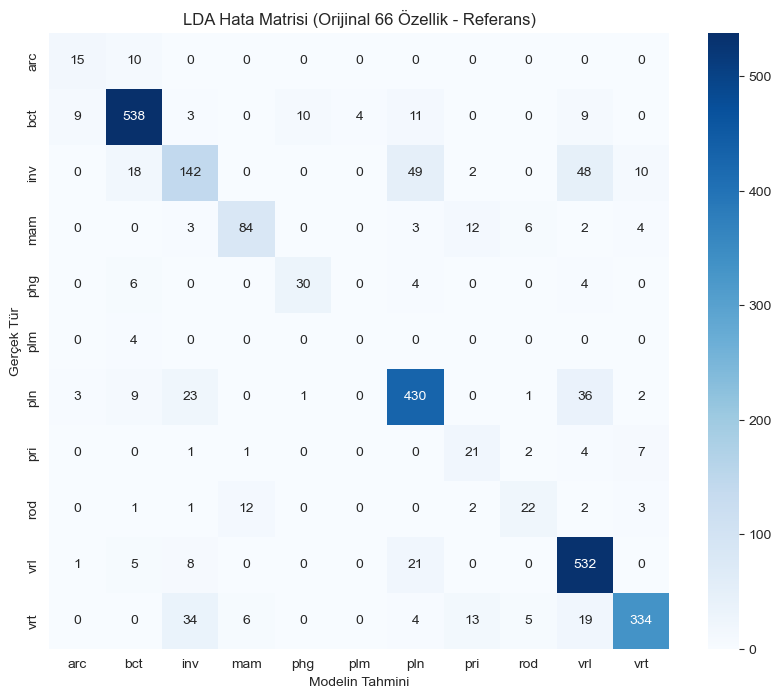

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


target_names = ['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod', 'vrl', 'vrt']

cm = confusion_matrix(y_test, lda_y_pred_orig)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("LDA Hata Matrisi (Orijinal 66 Özellik - Referans)")
plt.xlabel("Modelin Tahmini")
plt.ylabel("Gerçek Tür")
plt.show() 

### PCA ile Boyut İndirgeme (Feature Extraction)
Verideki varyansın (bilginin) %95'ini koruyacak şekilde özellik sayısı azaltılır.
*   PCA, birbirine korele olan özellikleri birleştirerek daha az sayıda ve birbirinden bağımsız bileşenler oluşturur.
*   Bu işlem hem gürültüyü azaltır hem de modelin aşırı öğrenmesini (overfitting) engeller.

In [53]:
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

n_components = X_train_pca.shape[1]

print("---- PCA SONUÇLARI ----")
print(f"Başlangıç Özellik Sayısı: {X_train.shape[1]}")
print(f"%95 varyans için gerekli bileşen sayısı: {n_components}")


---- PCA SONUÇLARI ----
Başlangıç Özellik Sayısı: 67
%95 varyans için gerekli bileşen sayısı: 43


### PCA Sonuçlarının 3 Boyutlu Görselleştirmesi
Veri setinin PCA sonrası ilk 3 bileşene indirgenmiş halinin uzaydaki dağılımı çizdirilir. Farklı krallıkların bu yeni uzayda birbirinden ne kadar iyi ayrıştığını gözlemlememizi sağlar.

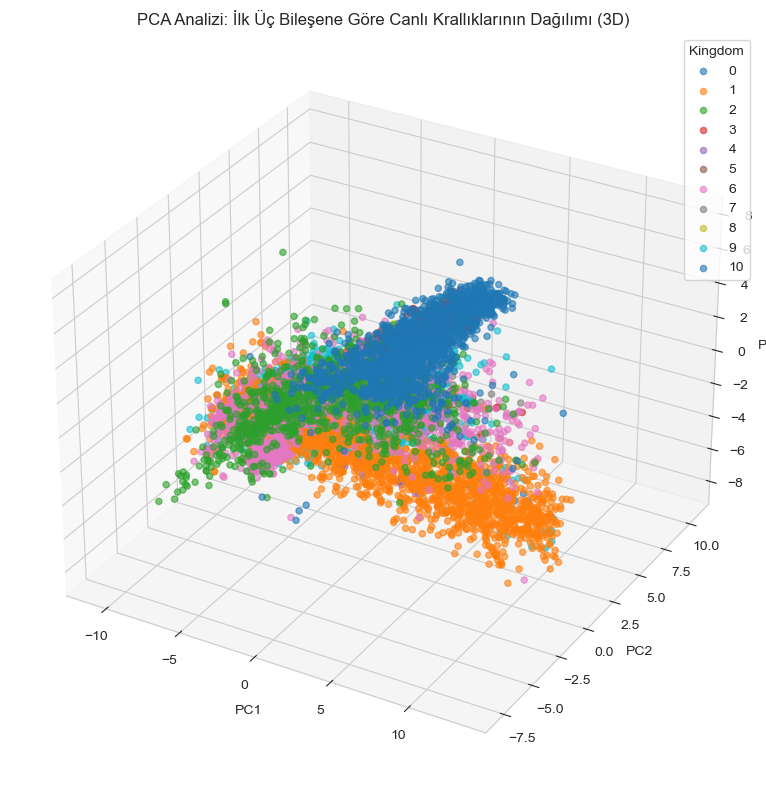

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


if X_train_pca.shape[1] >= 3:
   
    pca_3d_df = pd.DataFrame(data=X_train_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
    pca_3d_df['Kingdom'] = y_train_final.values
    
   
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
   
    for name, group in pca_3d_df.groupby('Kingdom'):
        ax.scatter(group['PC1'], group['PC2'], group['PC3'], 
                   label=name, 
                   alpha=0.6)

    ax.set_title('PCA Analizi: İlk Üç Bileşene Göre Canlı Krallıklarının Dağılımı (3D)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend(title='Kingdom')
    plt.tight_layout()
    plt.show()
else:
    print("PCA, 3 boyuttan daha az bileşen seçtiği için 3D görselleştirme atlandı.")

### PCA Sonrası LDA Modeli
Boyut indirgeme işlemi (PCA) uygulanmış veri seti üzerinde LDA modeli eğitilir ve performansı ölçülür.

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

lda_model_pca = LinearDiscriminantAnalysis()

lda_grid_search_pca = GridSearchCV(
    estimator=lda_model_pca,
    param_grid=lda_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Model Eğitimi (Varsayım: X_train_pca, y_train_final tanımlı)
lda_grid_search_pca.fit(X_train_pca, y_train_final)
best_lda_model_pca = lda_grid_search_pca.best_estimator_

# Tahmin ve Değerlendirme
lda_y_pred_pca = best_lda_model_pca.predict(X_test_pca)
lda_y_proba_pca = best_lda_model_pca.predict_proba(X_test_pca)

# Metrik Hesaplamaları
lda_f1_pca = f1_score(y_test_final, lda_y_pred_pca, average='weighted')
lda_auc_pca = roc_auc_score(y_test_final, lda_y_proba_pca, multi_class='ovo', average='weighted')
lda_pr_auc_pca = average_precision_score(y_test_final, lda_y_proba_pca, average='weighted')
lda_brier_scores_pca = [brier_score_loss((y_test_final == i).astype(int), lda_y_proba_pca[:, i]) for i in range(TARGET_CLASSES)]
lda_avg_brier_pca = np.mean(lda_brier_scores_pca)

print("\n--- LDA PERFORMANS RAPORU (PCA 43 Bileşen) ---")
print("En iyi parametreler:", lda_grid_search_pca.best_params_)
print("F1 Score:", round(lda_f1_pca, 4))
print("ROC AUC:", round(lda_auc_pca, 4))
print("PR AUC:", round(lda_pr_auc_pca, 4))
print("Brier Score:", round(lda_avg_brier_pca, 4))


--- LDA PERFORMANS RAPORU (PCA 43 Bileşen) ---
En iyi parametreler: {'shrinkage': None, 'solver': 'lsqr'}
F1 Score: 0.7934
ROC AUC: 0.9565
PR AUC: 0.8598
Brier Score: 0.0278


### Sıralı İleri Seçim (SFS) - Wrapper Yöntemi
SFS, özellikleri tek tek modele ekleyerek modelin performansını (F1 Skoru) en çok artıran 50 özelliklik kombinasyonu bulmaya çalışır.
Bu yöntem, özelliklerin model üzerindeki gerçek etkisini ölçtüğü için genellikle yüksek başarı sağlar ancak hesaplama maliyeti yüksektir.

In [56]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA modelini, özellik alt kümelerini değerlendirmek için kullanıyoruz.
lda_model_sfs = LinearDiscriminantAnalysis(solver='svd', shrinkage=None)


sfs = SFS(
    estimator=lda_model_sfs,
    k_features=50,
    forward=True,
    floating=False,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)

sfs.fit(X_train_final, y_train_final)

selected_indices_sfs = list(sfs.k_feature_idx_)

# Seçilmiş özellikleri yeni setlere dönüştürme
X_train_sfs_selected = X_train_final.iloc[:, selected_indices_sfs]
X_test_sfs_selected = X_test_final.iloc[:, selected_indices_sfs]

# Özellik isimlerini bulma
selected_feature_names_sfs = X_train_final.columns[selected_indices_sfs]

print("--- SFS SONUÇLARI (LDA Değerlendiricisi) ---")
print("Toplam özellik:", X_train_final.shape[1])
print("Seçilen özellik sayısı:", X_train_sfs_selected.shape[1])
print("İlk 10 özellik:", selected_feature_names_sfs[:10].tolist())


--- SFS SONUÇLARI (LDA Değerlendiricisi) ---
Toplam özellik: 67
Seçilen özellik sayısı: 50
İlk 10 özellik: ['DNAtype', 'UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU']


###  SFS Performans Eğrisi
Seçilen özellik sayısı arttıkça modelin başarısının nasıl değiştiğini gösteren grafik. Hangi noktadan sonra yeni özellik eklemenin performansa katkı sağlamadığını görmemize yardımcı olur.

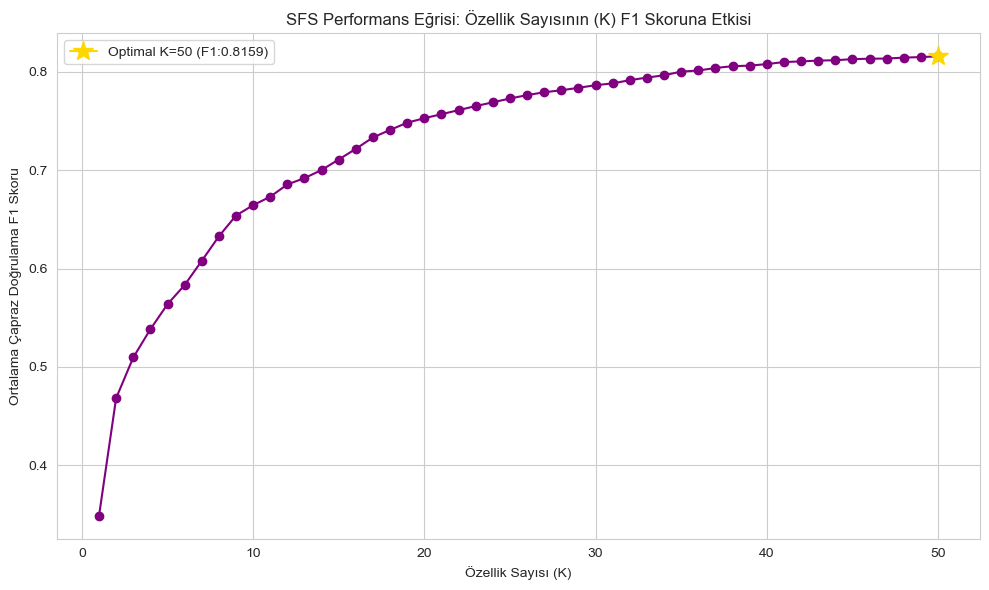

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

sfs_results_df = pd.DataFrame.from_dict(sfs.get_metric_dict(), orient='index')

plt.figure(figsize=(10, 6))
plt.plot(sfs_results_df.index, sfs_results_df['avg_score'], marker='o', color='purple')

best_k = sfs_results_df['avg_score'].idxmax()
best_score = sfs_results_df['avg_score'].max()
plt.plot(best_k, best_score, marker='*', markersize=15, color='gold', label=f'Optimal K={best_k} (F1:{best_score:.4f})')


plt.title('SFS Performans Eğrisi: Özellik Sayısının (K) F1 Skoruna Etkisi')
plt.xlabel('Özellik Sayısı (K)')
plt.ylabel('Ortalama Çapraz Doğrulama F1 Skoru')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###  SFS Sonrası LDA Modeli
Wrapper yöntemi (SFS) ile seçilen en iyi 50 özellik kullanılarak LDA modeli eğitilir ve test edilir.

In [58]:
lda_grid_search_sfs = GridSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_grid=lda_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

lda_grid_search_sfs.fit(X_train_sfs_selected, y_train_final)

best_lda_sfs = lda_grid_search_sfs.best_estimator_


lda_pred_sfs = best_lda_sfs.predict(X_test_sfs_selected)
lda_proba_sfs = best_lda_sfs.predict_proba(X_test_sfs_selected)

lda_f1_sfs = f1_score(y_test_final, lda_pred_sfs, average='weighted')
lda_auc_sfs = roc_auc_score(y_test_final, lda_proba_sfs, multi_class='ovo', average='weighted')
lda_pr_sfs = average_precision_score(y_test_final, lda_proba_sfs, average='weighted')
lda_brier_sfs = np.mean([
    brier_score_loss((y_test_final == i).astype(int), lda_proba_sfs[:, i])
    for i in range(TARGET_CLASSES)
])

print("\n--- LDA (SFS Seçilmiş 50 Özellik) ---")
print("Best Params:", lda_grid_search_sfs.best_params_)
print("F1:", round(lda_f1_sfs, 4))
print("ROC AUC:", round(lda_auc_sfs, 4))
print("PR AUC:", round(lda_pr_sfs, 4))
print("Brier:", round(lda_brier_sfs, 4))


--- LDA (SFS Seçilmiş 50 Özellik) ---
Best Params: {'shrinkage': None, 'solver': 'lsqr'}
F1: 0.8181
ROC AUC: 0.9645
PR AUC: 0.8829
Brier: 0.0243


###  ANOVA ile Özellik Seçimi - Filtreleme Yöntemi
Her bir özelliğin hedef değişkenle (Kingdom) olan istatistiksel ilişkisi (F-değeri) hesaplanır. 
En yüksek ilişkiye sahip (en ayırt edici) 50 özellik seçilir. Bu yöntem SFS'e göre çok daha hızlıdır.

In [59]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd

# 1. adım SelectKBest'i tanımlama ve fit etme 
k_best_selector_anova = SelectKBest(score_func=f_classif, k=50)
k_best_selector_anova.fit(X_train_final, y_train_final)

# 2. adım  Yeni ANOVA alt kümelerini oluştur
X_train_anova_selected = k_best_selector_anova.transform(X_train_final)
X_test_anova_selected = k_best_selector_anova.transform(X_test_final)

# Özellik isimlerini bulma
selected_mask_anova = k_best_selector_anova.get_support()
selected_feature_names_anova = X_train_final.columns[selected_mask_anova]


print("--- ANOVA FS SONUÇLARI (Top K=50) ---")
print(f"Seçilen özellik sayısı: {X_train_anova_selected.shape[1]}")
print(f"İlk 10 özellik: {selected_feature_names_anova[:10].tolist()}")

--- ANOVA FS SONUÇLARI (Top K=50) ---
Seçilen özellik sayısı: 50
İlk 10 özellik: ['DNAtype', 'UUC', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUC', 'AUA', 'AUG']


###  Seçilen Özelliklerin Dağılımı (Violin Plot)
ANOVA yöntemiyle seçilen en önemli özelliklerin, farklı sınıflar (krallıklar) içindeki dağılımı görselleştirilir. Bu grafik, seçilen özelliklerin sınıfları ayırmada neden başarılı olduğunu (veya olmadığını) gösterir.

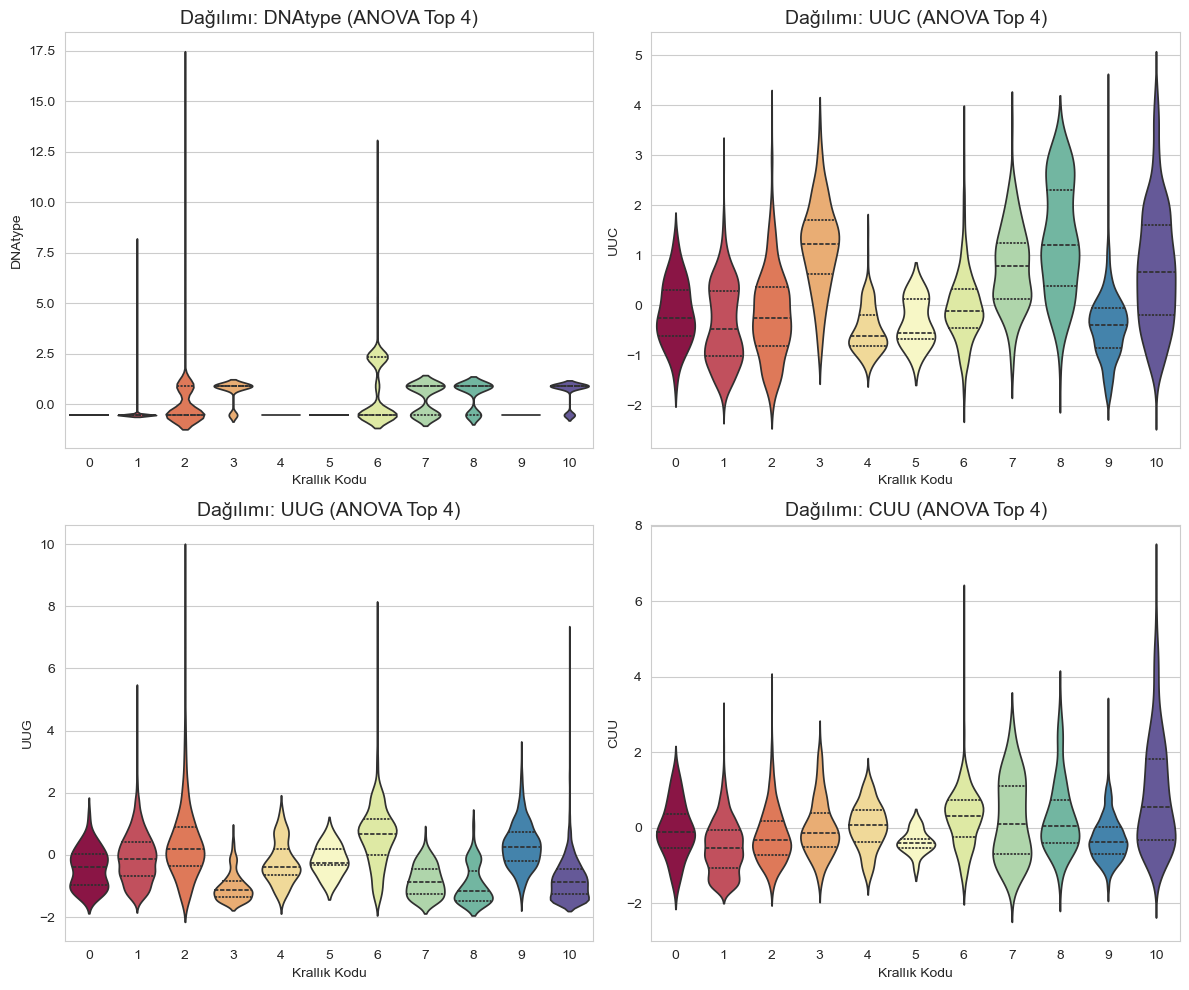

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top_4_anova_features = selected_feature_names_anova[:4].tolist()
plot_data = X_train_final.copy() 
plot_data['Kingdom'] = y_train_final.values

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
axes = axes.flatten()

# Her özellik için Violin Plot çizilir
for i, feature in enumerate(top_4_anova_features):
   
    sns.violinplot(x='Kingdom', y=feature, data=plot_data, ax=axes[i], inner='quartile', hue='Kingdom', palette='Spectral', legend=False)
    
    axes[i].set_title(f'Dağılımı: {feature} (ANOVA Top 4)', fontsize=14)
    axes[i].set_xlabel('Krallık Kodu')
    
plt.tight_layout()
plt.show()

### ANOVA Sonrası LDA Modeli
Filtreleme yöntemi (ANOVA) ile seçilen özellikler kullanılarak LDA modeli eğitilir ve performansı ölçülür.

In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

lda_grid_search_anova = GridSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_grid=lda_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

# ANOVA verisi üzerinde fit et
lda_grid_search_anova.fit(X_train_anova_selected, y_train_final)

best_lda_anova = lda_grid_search_anova.best_estimator_

# Tahmin ve Değerlendirme
lda_pred_anova = best_lda_anova.predict(X_test_anova_selected)
lda_proba_anova = best_lda_anova.predict_proba(X_test_anova_selected)


lda_f1_anova = f1_score(y_test_final, lda_pred_anova, average='weighted')
lda_auc_anova = roc_auc_score(y_test_final, lda_proba_anova, multi_class='ovo', average='weighted')
lda_pr_auc_anova = average_precision_score(y_test_final, lda_proba_anova, average='weighted')
lda_brier_scores_anova = [brier_score_loss((y_test_final == i).astype(int), lda_proba_anova[:, i]) for i in range(TARGET_CLASSES)]
lda_avg_brier_anova = np.mean(lda_brier_scores_anova)


print("\n--- LDA PERFORMANS RAPORU (ANOVA Seçilmiş 50 Özellik) ---")
print(f"En iyi parametreler: {lda_grid_search_anova.best_params_}")
print(f"F1 Score: {round(lda_f1_anova, 4)}")
print(f"ROC AUC: {round(lda_auc_anova, 4)}")
print(f"PR AUC: {round(lda_pr_auc_anova, 4)}")
print(f"Brier Score: {round(lda_avg_brier_anova, 4)}")


--- LDA PERFORMANS RAPORU (ANOVA Seçilmiş 50 Özellik) ---
En iyi parametreler: {'shrinkage': None, 'solver': 'svd'}
F1 Score: 0.8055
ROC AUC: 0.9628
PR AUC: 0.8698
Brier Score: 0.0262


### **Kapsamlı Sonuç Karşılaştırması**
Bu projede denenen tüm yaklaşımların (Tüm Özellikler, PCA, SFS, ANOVA) sonuçları bir tablo halinde karşılaştırılır.
*   F1 Skoru, ROC AUC, PR AUC gibi metrikler yan yana getirilerek, bu genetik veri seti için en uygun stratejinin hangisi olduğu belirlenir.

In [62]:
import pandas as pd
from IPython.display import display


lda_results = [
    {
        "Yöntem": "1. SFS (Sıralı İleri Seçim)",
        "F1 Skoru": lda_f1_sfs,
        "ROC AUC": lda_auc_sfs,
        "PR AUC": lda_pr_sfs,
        "Brier Score": lda_brier_sfs, 
        "Boyut Kontrol": "SFS (Wrapper)"
    },
    {
        "Yöntem": "2. ANOVA (F-Testi)",
        "F1 Skoru": lda_f1_anova,
        "ROC AUC": lda_auc_anova,
        "PR AUC": lda_pr_auc_anova,
        "Brier Score": lda_avg_brier_anova,
        "Boyut Kontrol": "ANOVA (Filter)"
    },
    {
        "Yöntem": "3. PCA (Temel Bileşenler)",
        "F1 Skoru": lda_f1_pca,
        "ROC AUC": lda_auc_pca,
        "PR AUC": lda_pr_auc_pca,
        "Brier Score": lda_avg_brier_pca,
        "Boyut Kontrol": "PCA (Extraction)"
    }
]

lda_comparison_df = pd.DataFrame(lda_results)

for col in ["F1 Skoru", "ROC AUC", "PR AUC", "Brier Score"]:
    lda_comparison_df[col] = lda_comparison_df[col].round(4)

lda_comparison_df = lda_comparison_df.sort_values(by="F1 Skoru", ascending=False)

print("\n--- LDA MODELİ: BOYUT İNDİRGEME YÖNTEMLERİNİN KARŞILAŞTIRILMASI ---")
print("Farklı özellik seçimi/çıkarımı yöntemlerinin performansı (F1'e göre sıralı):")
display(lda_comparison_df)


--- LDA MODELİ: BOYUT İNDİRGEME YÖNTEMLERİNİN KARŞILAŞTIRILMASI ---
Farklı özellik seçimi/çıkarımı yöntemlerinin performansı (F1'e göre sıralı):


,Yöntem,F1 Skoru,ROC AUC,PR AUC,Brier Score,Boyut Kontrol
0,1. SFS (Sıralı İleri Seçim),0.8181,0.9645,0.8829,0.0243,SFS (Wrapper)
1,2. ANOVA (F-Testi),0.8055,0.9628,0.8698,0.0262,ANOVA (Filter)
2,3. PCA (Temel Bileşenler),0.7934,0.9565,0.8598,0.0278,PCA (Extraction)




### **Sonuçların Yorumlanması ve PCA Paradoksu:**

Bu kapsamlı analizde, SFS (Sıralı İleri Seçim) yöntemi yüksek başarıyı elde ederken, PCA (Temel Bileşen Analizi)  düşük performans göstermiştir. Projeye PCA'nın dahil edilmesinin temel amacı, boyut indirgeme tekniklerinin her zaman başarıyı artırmadığını ve veri setinin yapısına göre (denetimli/denetimsiz) doğru yöntemi seçmenin önemini deneysel olarak göstermekti.
Genel beklentinin aksine PCA'nın geride kalmasının temel nedenleri şunlardır:

1.  **Denetimli vs. Denetimsiz Yaklaşım:** PCA, sınıflardan (Kingdom) habersiz "denetimsiz" bir yöntemdir ve sadece verideki çeşitliliği (varyansı) korumaya odaklanır. Ancak bu veri setinde, varyansı düşük olan bazı özellikler (örneğin nadir kodonlar) sınıfları ayırmada kritik öneme sahip olabilir. PCA bunları "gürültü" sanarak elediği için bilgi kaybı yaşamıştır.
2.  **Model Uyumu:** SFS yöntemi, özellikleri seçerken bizzat LDA modelini kullanır ("Wrapper" metod). Bu sayede LDA'nın matematiksel yapısına en uygun özellik setini bulmuş ve PCA'yı geride bırakmıştır.
3.  **İstatistiksel Güç:** ANOVA yöntemi, her özelliğin sınıflarla olan ilişkisini test ettiği ("Filter" metod) için, hedef odaklıdır ve PCA'ya göre daha ayırt edici özellikleri yakalamıştır.

**Sonuç:** Bu çalışma, "Her veri setinde en iyi çalışan tek bir yöntem yoktur" ilkesini doğrulamaktadır. Genetik kodon verileri ve LDA modeli için SFS kullanımı, PCA'ya göre daha üstün bir performans sağlar.   